# 04. Quick Application: Optical Character Recognition

이번에는 조금 더 흥미로운 문제에 대해 설명하기 위해 OCR(Optical Character Incognition)에 적용해 보겠습니다. 손으로 쓴 숫자를 인식하는 머신러닝 모델을 만들어 보도록 하겠습니다.
실제 상황에서 이 문제는 이미지에서 문자를 찾고 식별하는 것을 다 해결해야하지만, 여기서 저희는 지름길로 가서 미리 만들어진 숫자 데이터셋을 사용하겠습니다. 이 데이터는 패키지 자체에 내장되어 있습니다.

### 데이터 불러오기와 시각화

scikit-learn에서 제공하는 data access interface를 사용하겠습니다. 데이터를 한번 확인해 봅시다.

In [1]:
from sklearn import datasets
digits = datasets.load_digits()
digits.images.shape

(1797, 8, 8)

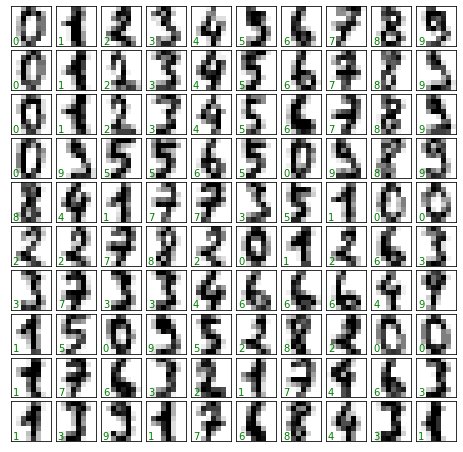

In [2]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(10, 10, figsize=(8, 8))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(digits.target[i]),
            transform=ax.transAxes, color='green')
    ax.set_xticks([])
    ax.set_yticks([])

이 데이터는 8x8격자에 픽셀값을 갖고 있는 단순한 데이터입니다.

In [3]:
# 이미지 그 자체 입니다.
print(digits.images.shape)
print(digits.images[0])

(1797, 8, 8)
[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]


In [4]:
# 알고리즘에서 사용하는 데이터 형식은 아래와 같습니다.
print(digits.data.shape)
print(digits.data[0])

(1797, 64)
[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]


In [6]:
# The target label
print(digits.target)

[0 1 2 ... 8 9 8]


살펴본 바로는 1797개의 64차원 데이터입니다.

### 비지도 학습: 차원 축소

64차원 데이터 공간에서 점들을 시각화하려고 합니다. 하지만 64차원으로는 점들을 찍을 수가 없습니다!
대신에 비지도 학습을 이용하여 차원을 2개로 축소를 할 것입니다. 여기서, *Isomap*이라는 알고리즘을 사용하겠습니다.

In [7]:
from sklearn.manifold import Isomap

In [8]:
iso = Isomap(n_components=2)
data_projected = iso.fit_transform(digits.data)

In [9]:
data_projected.shape

(1797, 2)

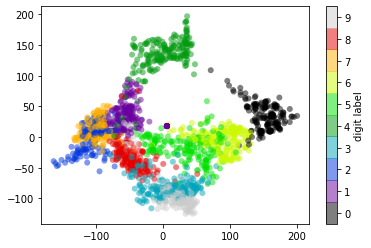

In [10]:
plt.scatter(data_projected[:, 0], data_projected[:, 1], c=digits.target,
            edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('nipy_spectral', 10));
plt.colorbar(label='digit label', ticks=range(10))
plt.clim(-0.5, 9.5)

머신러닝을 분석이 가능하겠다!

여기서 차원축소된 공간에서 숫자가 상당히 잘 구분되어 있음을 알 수 있습니다. 이를 통해, 지도학습 알고리즘 또한 잘 수행될 수 있음을 짐작할 수 있습니다. 한번 아래에서 함께 수행해 봅시다.

### 숫자 분류

이제 숫자를 분류하는 작업을 시작해 봅시다. 가장 처음으로 할 일은 학습데이터와 테스트데이터를 나누는 것입니다.

In [11]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,
                                                random_state=2)
print(Xtrain.shape, Xtest.shape)

(1347, 64) (450, 64)


단순 로지스틱 회귀알고리즘을 사용해 봅시다. 이름에 회귀라는 단어가 있어서 헷갈릴 수 있으나, 분류 알고리즘 맞습니다. 

In [12]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l2')
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


분류 정확도는 테스트셋의 예측 정확도를 비교하는 것으로 판단 가능 합니다.

In [14]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, ypred)

0.9466666666666667

이 하나의 숫자로는 **어디서** 잘못 분류하였는지 알 수가 없습니다. 이를 알 수 있는 방법이 *confusion matrix*입니다.

In [15]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, ypred))

[[41  0  0  0  1  0  0  0  0  0]
 [ 0 46  0  1  0  0  0  0  2  1]
 [ 0  0 47  0  0  0  0  0  0  0]
 [ 0  0  0 44  0  1  0  1  2  0]
 [ 0  0  0  0 36  0  0  0  3  1]
 [ 0  1  0  0  1 50  0  0  0  0]
 [ 0  1  0  0  0  0 41  0  1  0]
 [ 0  0  0  0  0  0  0 48  1  0]
 [ 0  0  0  0  0  0  0  0 39  1]
 [ 0  0  0  2  0  1  0  0  2 34]]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


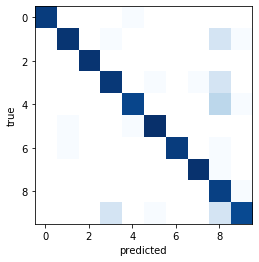

In [16]:
import numpy as np
plt.imshow(np.log(confusion_matrix(ytest, ypred)),
           cmap='Blues', interpolation='nearest')
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted');

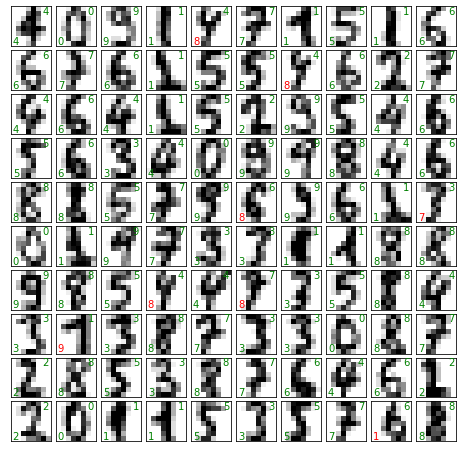

In [17]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, ax in enumerate(axes.flat):
    ax.imshow(Xtest[i].reshape(8, 8), cmap='binary')
    # 예측값
    ax.text(0.05, 0.05, str(ypred[i]),
            transform=ax.transAxes,
            color='green' if (ytest[i] == ypred[i]) else 'red')
    # 실제값
    ax.text(0.80, 0.80, str(ytest[i]),
            transform=ax.transAxes,
            color='green')
    ax.set_xticks([])
    ax.set_yticks([])